In [1]:
from utils.load_results import *
from utils.plot_helpers import *

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
datasets = ['(3,4)', '(3,8)', '(3,16)', '(4,4)', '(4,8)', '(5,4)']
n_values = [4, 8, 16, 4, 8, 4]
n_attributes = [3, 3, 3, 4, 4, 5]
n_epochs = 300
n_datasets = len(datasets)
paths = ['results/' + d + '_sample_scaling_10_balanced_False_vsf_3/' for d in datasets]

## training

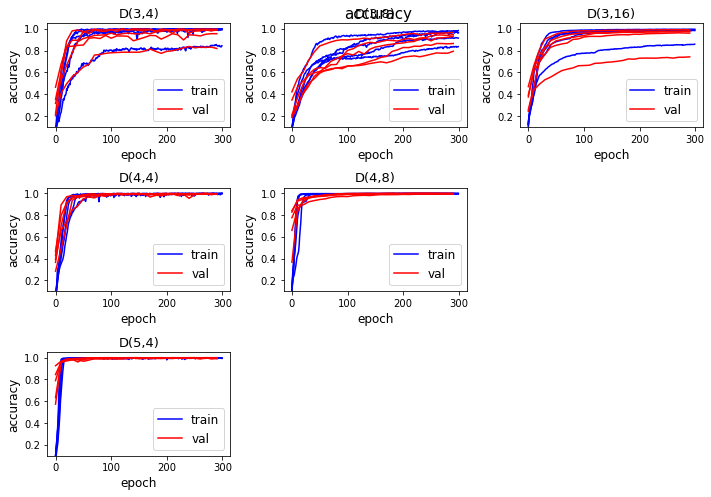

In [3]:
all_accuracies = load_accuracies(paths)
plot_training_trajectory(all_accuracies['train_acc'], all_accuracies['val_acc'], ylim=(0.1, 1.05), steps=(1, 10))

## final accuracies 

In [4]:
all_accuracies = load_accuracies(paths)
accuracies = [all_accuracies['train_acc'], all_accuracies['val_acc'], 
              all_accuracies['zs_acc_objects'], all_accuracies['zs_acc_abstraction']]

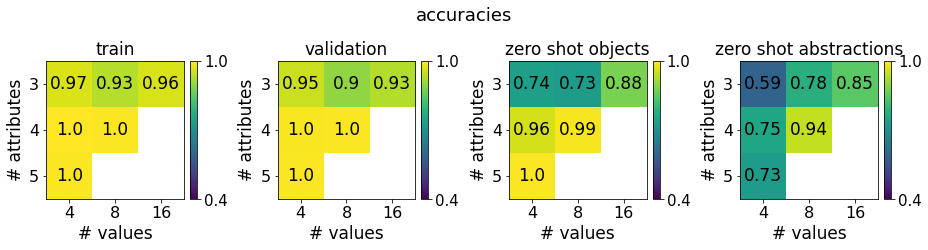

In [11]:
plot_heatmap(accuracies, 'mean', plot_dims=(1, 4), ylims=(0.4, 1.0), figsize=(13, 3.5), suptitle='accuracies', 
             fontsize=17)

## entropy scores 

In [21]:
entropy_scores = load_entropies(paths)
entropies = [entropy_scores['NI'], entropy_scores['effectiveness'], entropy_scores['consistency']]

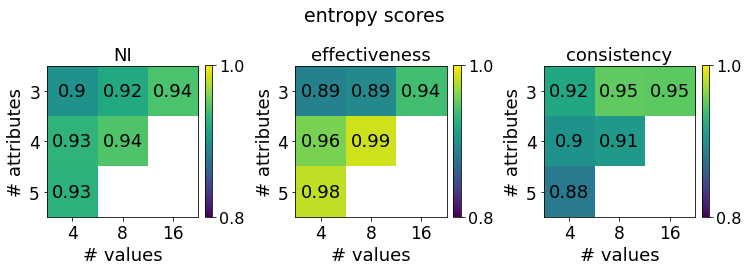

In [23]:
plot_heatmap(entropies, 'mean', plot_dims=(1,3), ylims=(0.8, 1.0), figsize=(10.5, 3.5), 
             titles = ('NI', 'effectiveness', 'consistency'), suptitle='entropy scores')

In [24]:
data_list, run_list, level_list = [], [], []
NMI_hierarchical, effectiveness_hierarchical, consistency_hierarchical = [], [], []

for d, data in enumerate(datasets):
    for run in range(5):
        
        scores = pickle.load(open(paths[d] + 'standard/' + str(run) + '/entropy_scores.pkl', 'rb'))
        
        for l, level in enumerate([1, 2, 3, 4, 5]):  
            
            data_list.append(data)
            run_list.append(run)
            level_list.append(level)
            
            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_hierarchical'][l])
                effectiveness_hierarchical.append(scores['effectiveness_hierarchical'][l])
                consistency_hierarchical.append(scores['consistency_hierarchical'][l])
            except: 
                NMI_hierarchical.append(np.nan)
                effectiveness_hierarchical.append(np.nan)
                consistency_hierarchical.append(np.nan)

entropy_dict_hierarchical = {'data': data_list, 'level': level_list, 'run': run_list, 'NI': NMI_hierarchical, 
                             'effectiveness': effectiveness_hierarchical, 'consistency': consistency_hierarchical}


In [30]:
all_hierarchical = {}
all_hierarchical['metric'] = ['NI'] * 150 + ['effectiveness'] * 150 + ['consistency'] * 150 
all_hierarchical['value'] = (entropy_dict_hierarchical['NI'] + 
                             entropy_dict_hierarchical['effectiveness'] + 
                             entropy_dict_hierarchical['consistency'])
all_hierarchical['level'] = entropy_dict_hierarchical['level'] * 3

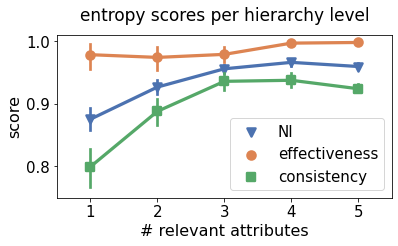

In [31]:
plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_hierarchical, hue='metric', 
                   markers=['v', 'o', 's'], palette='deep', scale=1.2)
plt.ylabel('score', fontsize=16)
plt.title('entropy scores per hierarchy level', fontsize=17, y=1.05)
plt.ylim([0.75,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5])
plt.yticks(ticks=[0.8, 0.9, 1.0], fontsize=15)
plt.xlabel('# relevant attributes', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(fontsize=15)
plt.show()

## message length and symbol redundancy

In [13]:
ml_dict = {'level': [], 'data set': [], 'run': [], 'message length': []}
for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        # if evaluated after training from interaction this is an array showing the message length
        # per level of concreteness (most abstract --> most concrete)
        ml_hierarchical = pickle.load(open(paths[d] + 'standard/' + str(run) + 
                                           '/message_length_hierarchical.pkl', 'rb'))
        
        # if evaluated with the callback throughout training, you get an array for each epoch
        if isinstance(ml_hierarchical, dict): 
            ml_hierarchical = ml_hierarchical['message_length_train'][n_epochs]
            
        for level in range(5):
            
            ml_dict['level'].append(level)
            ml_dict['run'].append(run)
            ml_dict['data set'].append(dataset)
            try: 
                ml_dict['message length'].append(ml_hierarchical[level])
            except: 
                ml_dict['message length'].append(np.NaN)

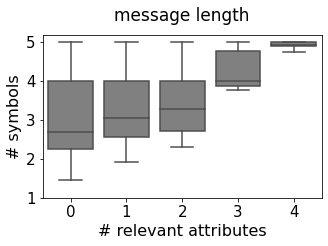

In [14]:
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='message length', data=ml_dict, color='gray')
plt.xticks(fontsize=15)
plt.yticks(ticks=[1,2,3,4,5], labels=[1,2,3,4,5], fontsize=15)
plt.xlabel('# relevant attributes', fontsize=16)
plt.ylabel('# symbols', fontsize=16)
plt.title('message length', fontsize=17, y=1.05)
plt.show()

In [15]:
symbol_redundancy_dict = {'level': [], 'data set': [], 'run': [], 'symbol frequency': []}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        scores = pickle.load(open(paths[d] + 'standard/' + str(run) + '/symbol_redundancy.pkl', 'rb'))
            
        for level in range(5):
            
            symbol_redundancy_dict['level'].append(level)
            symbol_redundancy_dict['run'].append(run)
            symbol_redundancy_dict['data set'].append(dataset)
            try: 
                symbol_redundancy_dict['symbol frequency'].append(scores['symbol_redundancy'][level])
            except: 
                symbol_redundancy_dict['symbol frequency'].append(np.NaN)

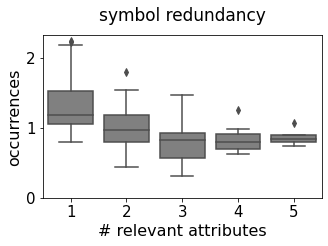

In [16]:
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='symbol frequency', data=symbol_redundancy_dict, color='gray')
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5], fontsize=15)
plt.yticks(ticks=[0, 1, 2], fontsize=15)
plt.xlabel('# relevant attributes', fontsize=16)
plt.ylabel('occurrences', fontsize=16)
plt.title('symbol redundancy', fontsize=17, y=1.05)
plt.show()

## compositionality

In [24]:
topsim, posdis, bosdis = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))
topsim_concrete, posdis_concrete, bosdis_concrete = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        topsim_score = pickle.load(open(paths[d] + 'standard/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent_score = pickle.load(open(paths[d] + 'standard/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        topsim[d, run] = topsim_score['topsim_train']
        posdis[d, run] = disent_score['posdis']
        bosdis[d, run] = disent_score['bosdis']
        topsim_concrete[d, run] = topsim_score['topsim_max_relevance_train']
        posdis_concrete[d, run] = disent_score['posdis_max_relevance']
        bosdis_concrete[d, run] = disent_score['bosdis_max_relevance']

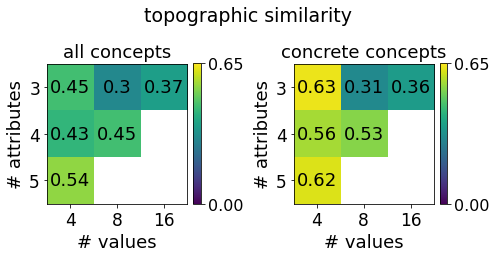

In [29]:
plot_heatmap([topsim, topsim_concrete], 'mean', plot_dims=(1,2), ylims=[0.0,0.65], figsize=(7,3.5), 
             titles=['all concepts', 'concrete concepts'], suptitle='topographic similarity', suptitle_position=1.)

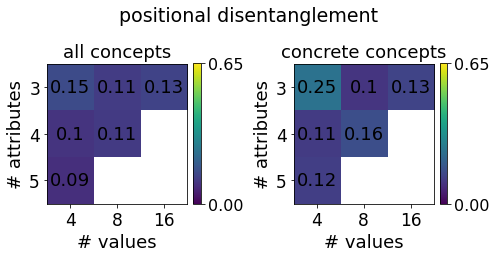

In [31]:
plot_heatmap([posdis, posdis_concrete], 'mean', plot_dims=(1,2), ylims=[0.0,0.65], figsize=(7,3.5),
             titles=['all concepts', 'concrete concepts'], suptitle='positional disentanglement', suptitle_position=1.)

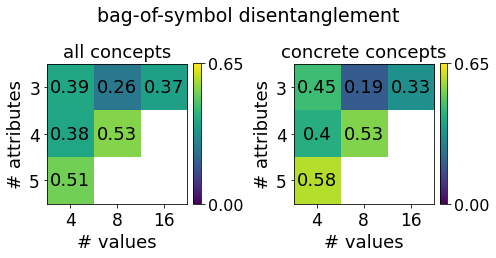

In [33]:
plot_heatmap([bosdis, bosdis_concrete], 'mean', plot_dims=(1,2), ylims=[0.0,0.65], figsize=(7,3.5),
             titles=['all concepts', 'concrete concepts'], suptitle='bag-of-symbol disentanglement', suptitle_position=1.)

In [3]:
# compositionality scores for each data set

compositionality_scores = {'dataset':[], 'run':[], 'metric':[], 'data':[], 'score':[]}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        topsim = pickle.load(open(paths[d] + 'standard/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent = pickle.load(open(paths[d] + 'standard/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        
        for metric in ['topsim', 'posdis', 'bosdis']:
            for data in ['all', 'concrete']: 
                
                compositionality_scores['dataset'].append(dataset)
                compositionality_scores['run'].append(run)
                compositionality_scores['metric'].append(metric)
                compositionality_scores['data'].append(data)
                
                append = '' if data == 'all' else '_max_relevance'
                    
                if metric == 'topsim':
                    compositionality_scores['score'].append(topsim['topsim' + append + '_train'])
                if metric == 'posdis':
                    compositionality_scores['score'].append(disent['posdis' + append])
                if metric == 'bosdis':
                    compositionality_scores['score'].append(disent['bosdis' + append])

compositionality_scores = pd.DataFrame(compositionality_scores)

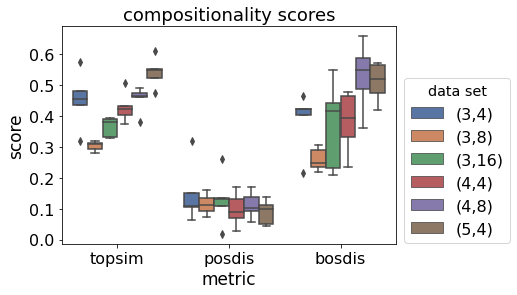

In [6]:
sns.boxplot(x='metric', y='score', data=compositionality_scores[compositionality_scores.data=='all'], 
            hue='dataset', palette='deep')
plt.xlabel(xlabel='metric', fontsize=17)
plt.ylabel(ylabel='score', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend = plt.legend(fontsize=16, title='data set', bbox_to_anchor=(1., 0.8))
plt.setp(legend.get_title(),fontsize='x-large')
plt.title('compositionality scores', fontsize=18)
plt.show()

In [ ]:
# compositionality scores for different vocab size factors 

compositionality_scores = {'vs factor':[], 'run':[], 'metric':[], 'score':[]}

for vsf in [1, 2, 3, 4]: 
    for run in range(5):
        
        path = 'results/(4,8)_sample_scaling_10_balanced_False_vsf_' + str(vsf) + '/'
        
        topsim = pickle.load(open(path + 'standard/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent = pickle.load(open(path + 'standard/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        
        for metric in ['topsim', 'posdis', 'bosdis']:
                
                compositionality_scores['vs factor'].append(vsf)
                compositionality_scores['run'].append(run)
                compositionality_scores['metric'].append(metric)

                if metric == 'topsim':
                    compositionality_scores['score'].append(topsim['topsim_train'])
                if metric == 'posdis':
                    compositionality_scores['score'].append(disent['posdis'])
                if metric == 'bosdis':
                    compositionality_scores['score'].append(disent['bosdis'])

compositionality_scores = pd.DataFrame(compositionality_scores)

## co-occurrences

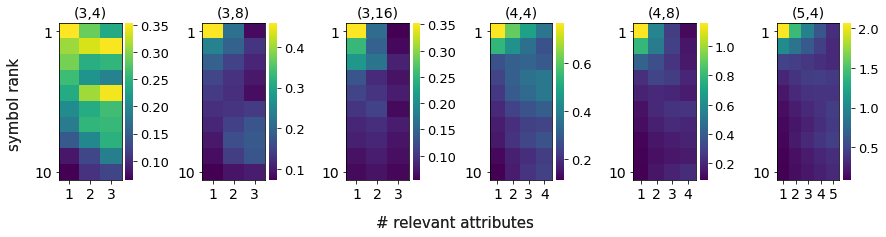

In [8]:
full_plot = False

fig = plt.figure(figsize=(12,3))

for d, dim in enumerate(datasets): 
    
    data = datasets[d]
    path = paths[d]
    vs_factor = int(path[-2])
    vocab_size = (n_values[d] + 1) * vs_factor + 1
    colors = plt.cm.jet(np.linspace(0,1,vocab_size))
    
    average_cooccurences = []
    
    plt.subplot(1,6,d+1)
    
    for run in range(5):
        
        cooccurences = pickle.load(open(paths[d] + 'standard/' + str(run) + '/normalized_cooccurrence.pkl', 'rb'))
        indices = np.flip(np.argsort(cooccurences[:,-1]))
        cooccurences = cooccurences[indices]
        average_cooccurences.append(cooccurences)
        
    average_cooccurences = np.flip(np.mean(average_cooccurences, axis=0), axis=1)
    
    data_dict = {}
    data_dict['symbol rank'] = []
    data_dict['level'] = []
    data_dict['value'] = []
    for symbol in indices:
        for level in range(average_cooccurences.shape[1]):
            data_dict['symbol rank'].append(symbol+1)
            data_dict['level'].append(level)
            data_dict['value'].append(average_cooccurences[symbol, level])
    
    if full_plot:
        g = sns.heatmap(average_cooccurences, cmap='viridis')
        plt.yticks(ticks=[0.5,vocab_size-1.5], labels=[1,vocab_size], fontsize=14)
    else: 
        g = sns.heatmap(average_cooccurences[0:10,:], cmap='viridis')
        plt.yticks(ticks=[0.5,9.5], labels=[1,10], fontsize=14, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=13)
    for _, spine in g.spines.items():
        spine.set_visible(True)
    #plt.xlabel('# relevant attributes', fontsize=14)
    #plt.ylabel('symbol rank', fontsize=14)
    plt.xticks(ticks=np.arange(n_attributes[d])+0.5, labels=range(1,n_attributes[d]+1), fontsize=14)
    plt.title(data, fontsize=14)
    
    fig.text(0.5, -0.05, '# relevant attributes', ha='center', va='center', fontsize=15, alpha=0.3)
    fig.text(-0.01, 0.5, 'symbol rank', ha='center', va='center', rotation='vertical', fontsize=15, alpha=0.3)

plt.tight_layout()